<a href="https://colab.research.google.com/github/saracherif123/Optimizing-File-Similarity-Search-Techniques-in-Data-Lakes-using-Big-Data-Frameworks-/blob/main/Random_Forest_datesets_duplicates_match_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Random Forest datesets_duplicates_match (Dup Model)**



## Spark Confirguration in Google Colab






In [1]:
!ls

all_topics_datasets_matching.csv  spark-3.1.1-bin-hadoop3.2
sample_data			  spark-3.1.1-bin-hadoop3.2.tgz


In [2]:
!pwd

/content


In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [5]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark


### Import necessary libraries

In [6]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StandardScaler



### Load Dataset

In [7]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Clustering using K-Means").getOrCreate()
data = spark.read.csv("all_topics_datasets_matching.csv", header=True, inferSchema=True)
data.show(10)


+----+----+-------------+--------------------+-------------+--------------+--------------+----------------+----------------+----------------+----------------+------------------+-----------------+------------------+------------------+----------------+---------------+----------------+----------------+----------------+----------------+-------------------------+-------------------------+-------------------------+-------------------------+----------------------+--------------------------+---------------------------+-------------------------+
|did1|did2|dataset_name1|       dataset_name2|num_instances|num_attributes|dimensionality|num_numeric_attr|pct_numeric_attr|num_nominal_attr|pct_nominal_attr|avg_nominal_values|sd_nominal_values|min_nominal_values|max_nominal_values|avg_numeric_mean|sd_numeric_mean|min_numeric_mean|max_numeric_mean|missing_attr_cnt|missing_attr_pct|missing_instances_max_cnt|missing_instances_max_pct|missing_instances_min_cnt|missing_instances_min_pct|missing_instances_m

In [8]:
data.printSchema()

root
 |-- did1: integer (nullable = true)
 |-- did2: integer (nullable = true)
 |-- dataset_name1: string (nullable = true)
 |-- dataset_name2: string (nullable = true)
 |-- num_instances: double (nullable = true)
 |-- num_attributes: double (nullable = true)
 |-- dimensionality: double (nullable = true)
 |-- num_numeric_attr: double (nullable = true)
 |-- pct_numeric_attr: double (nullable = true)
 |-- num_nominal_attr: double (nullable = true)
 |-- pct_nominal_attr: double (nullable = true)
 |-- avg_nominal_values: double (nullable = true)
 |-- sd_nominal_values: double (nullable = true)
 |-- min_nominal_values: double (nullable = true)
 |-- max_nominal_values: double (nullable = true)
 |-- avg_numeric_mean: double (nullable = true)
 |-- sd_numeric_mean: double (nullable = true)
 |-- min_numeric_mean: double (nullable = true)
 |-- max_numeric_mean: double (nullable = true)
 |-- missing_attr_cnt: double (nullable = true)
 |-- missing_attr_pct: double (nullable = true)
 |-- missing_ins

## Data Preprocessing

In [9]:
data=data.drop("did1","did2","dataset_name1","dataset_name2")
data

num_instances,num_attributes,dimensionality,num_numeric_attr,pct_numeric_attr,num_nominal_attr,pct_nominal_attr,avg_nominal_values,sd_nominal_values,min_nominal_values,max_nominal_values,avg_numeric_mean,sd_numeric_mean,min_numeric_mean,max_numeric_mean,missing_attr_cnt,missing_attr_pct,missing_instances_max_cnt,missing_instances_max_pct,missing_instances_min_cnt,missing_instances_min_pct,missing_instances_mean,missing_instances_mean_pct,datesets_subject_main_match,datesets_duplicates_match
0.747015,0.0,0.747015,1.0,1.0,0.833333,0.833333,0.992834,0.993118,0.333333,0.984317,1.0,1.0,0.0,1.0,0.8,0.8,0.870968,0.967357,0.95,0.80236,0.911111,0.977512,0,0
0.996786,0.976654,0.862327,1.0,1.0,0.666667,0.992218,0.870246,0.838809,0.0,0.671875,1.0,1.0,1.0,1.0,0.990476,0.592063,0.99177,0.60947,0.0,0.996786,0.987738,0.73788,0,0
0.843658,0.333333,0.765487,1.0,1.0,0.944444,0.916667,0.939203,1.0,0.962264,0.603774,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0
0.0678466,0.333333,0.28481,1.0,1.0,0.833333,0.75,0.0333333,0.891071,0.333333,0.809524,1.0,1.0,1.0,1.0,0.375,0.583333,0.851613,0.840813,0.5,0.533923,0.626667,0.599494,0,0
0.823009,0.0555556,0.812598,1.0,1.0,0.166667,0.117647,0.121212,0.838432,0.333333,0.761905,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0
0.987917,0.611111,0.995301,1.0,1.0,0.777778,0.428571,0.660819,0.163264,0.5,0.142857,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0
0.951703,0.704918,0.836325,0.0,0.0,0.704918,0.0,0.934284,0.954003,0.5,0.956967,0.0,0.0,0.0,0.0,0.722222,0.0586419,0.975303,0.488643,0.992593,0.84663,0.984144,0.671701,0,0
0.0678466,0.333333,0.28481,1.0,1.0,0.833333,0.75,0.0333333,0.891071,0.333333,0.809524,1.0,1.0,1.0,1.0,0.375,0.583333,0.851613,0.840813,0.5,0.533923,0.626667,0.599494,0,0
0.687316,0.444444,0.437168,1.0,1.0,0.944444,0.9,0.462963,1.0,0.666667,0.714286,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0
0.999669,0.388889,0.999798,1.0,1.0,0.944444,0.909091,0.677778,1.0,0.8,0.52381,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0


In [10]:
# Create vector assembler
labelCol = 'datesets_duplicates_match'
numericCols = ['num_instances','num_attributes',
 'dimensionality','num_numeric_attr','pct_numeric_attr','num_nominal_attr', 'pct_nominal_attr',
 'avg_nominal_values','sd_nominal_values','min_nominal_values','max_nominal_values','avg_numeric_mean',
 'sd_numeric_mean','min_numeric_mean','max_numeric_mean','missing_attr_cnt','missing_attr_pct',
 'missing_instances_max_cnt','missing_instances_max_pct','missing_instances_min_cnt','missing_instances_min_pct',
 'missing_instances_mean','missing_instances_mean_pct']
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")

# Transform the  data
data = assembler.transform(data)



### Cluster-based undersampling


In [11]:
# Filter the data where `datesets_duplicates_match` is equal to zero
filtered_data_0 = data.filter(col("datesets_duplicates_match") == 0)

# Show the filtered data
filtered_data_0.show()



+-------------+--------------+--------------+----------------+----------------+----------------+----------------+------------------+-----------------+------------------+------------------+----------------+---------------+----------------+----------------+----------------+----------------+-------------------------+-------------------------+-------------------------+-------------------------+----------------------+--------------------------+---------------------------+-------------------------+--------------------+
|num_instances|num_attributes|dimensionality|num_numeric_attr|pct_numeric_attr|num_nominal_attr|pct_nominal_attr|avg_nominal_values|sd_nominal_values|min_nominal_values|max_nominal_values|avg_numeric_mean|sd_numeric_mean|min_numeric_mean|max_numeric_mean|missing_attr_cnt|missing_attr_pct|missing_instances_max_cnt|missing_instances_max_pct|missing_instances_min_cnt|missing_instances_min_pct|missing_instances_mean|missing_instances_mean_pct|datesets_subject_main_match|datesets_d

In [12]:

# Count the number of records in the filtered DataFrame
num_records_0 = filtered_data_0.count()

# Print the count
print("Number of records where 'datesets_duplicates_match' is equal to zero:", num_records_0)

Number of records where 'datesets_duplicates_match' is equal to zero: 22450


In [13]:
# Filter the data where `datesets_duplicates_match` is equal to one
filtered_data_1 = data.filter(col("datesets_duplicates_match") == 1)

# Show the filtered data
filtered_data_1.show()


+-------------+--------------+--------------+----------------+----------------+----------------+----------------+------------------+-----------------+------------------+------------------+----------------+---------------+----------------+----------------+----------------+----------------+-------------------------+-------------------------+-------------------------+-------------------------+----------------------+--------------------------+---------------------------+-------------------------+--------------------+
|num_instances|num_attributes|dimensionality|num_numeric_attr|pct_numeric_attr|num_nominal_attr|pct_nominal_attr|avg_nominal_values|sd_nominal_values|min_nominal_values|max_nominal_values|avg_numeric_mean|sd_numeric_mean|min_numeric_mean|max_numeric_mean|missing_attr_cnt|missing_attr_pct|missing_instances_max_cnt|missing_instances_max_pct|missing_instances_min_cnt|missing_instances_min_pct|missing_instances_mean|missing_instances_mean_pct|datesets_subject_main_match|datesets_d

In [14]:

# Count the number of records in the filtered DataFrame
num_records_1 = filtered_data_1.count()

# Print the count
print("Number of records where 'datesets_duplicates_match' is equal to one:", num_records_1)

Number of records where 'datesets_duplicates_match' is equal to one: 128


In [15]:
#Standard scaling the filtered datasets
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(filtered_data_0)
data_scale_output_0=data_scale.transform(filtered_data_0)
data_scale_output_0.show(2)

+-------------+--------------+--------------+----------------+----------------+----------------+----------------+------------------+-----------------+------------------+------------------+----------------+---------------+----------------+----------------+----------------+----------------+-------------------------+-------------------------+-------------------------+-------------------------+----------------------+--------------------------+---------------------------+-------------------------+--------------------+--------------------+
|num_instances|num_attributes|dimensionality|num_numeric_attr|pct_numeric_attr|num_nominal_attr|pct_nominal_attr|avg_nominal_values|sd_nominal_values|min_nominal_values|max_nominal_values|avg_numeric_mean|sd_numeric_mean|min_numeric_mean|max_numeric_mean|missing_attr_cnt|missing_attr_pct|missing_instances_max_cnt|missing_instances_max_pct|missing_instances_min_cnt|missing_instances_min_pct|missing_instances_mean|missing_instances_mean_pct|datesets_subject_

In [16]:
#Standard scaling the filtered datasets
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(filtered_data_1)
data_scale_output_1=data_scale.transform(filtered_data_1)
data_scale_output_1.show(2)


+-------------+--------------+--------------+----------------+----------------+----------------+----------------+------------------+-----------------+------------------+------------------+----------------+---------------+----------------+----------------+----------------+----------------+-------------------------+-------------------------+-------------------------+-------------------------+----------------------+--------------------------+---------------------------+-------------------------+--------------------+--------------------+
|num_instances|num_attributes|dimensionality|num_numeric_attr|pct_numeric_attr|num_nominal_attr|pct_nominal_attr|avg_nominal_values|sd_nominal_values|min_nominal_values|max_nominal_values|avg_numeric_mean|sd_numeric_mean|min_numeric_mean|max_numeric_mean|missing_attr_cnt|missing_attr_pct|missing_instances_max_cnt|missing_instances_max_pct|missing_instances_min_cnt|missing_instances_min_pct|missing_instances_mean|missing_instances_mean_pct|datesets_subject_

## Clustering Dataset Using Kmeans
Choice of K based on Elbow Method

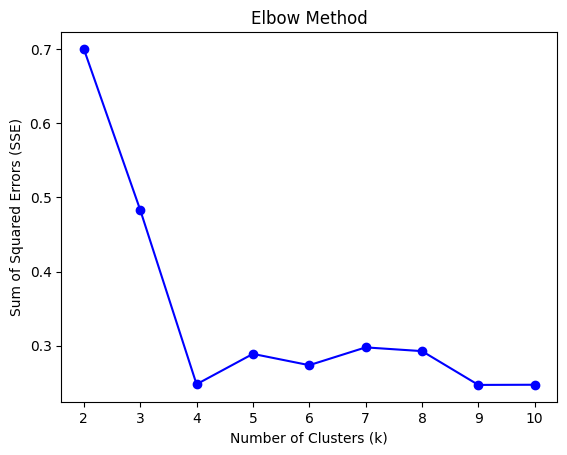

In [17]:
# Create an empty list to store the SSE (Sum of Squared Errors) values
sse = []

# Define the range of cluster numbers to evaluate
k_values = range(2, 11)  # Range from 2 to 10 clusters

# Iterate over each cluster number
for k in k_values:
    # Create a KMeans instance with the current cluster number
    kmeans = KMeans(featuresCol='standardized', k=k)

    # Fit the KMeans model to the data
    model = kmeans.fit(data_scale_output_0)

    # Make predictions on the data
    predictions = model.transform(data_scale_output_0)

    # Evaluate the clustering performance using the SSE metric
    evaluator = ClusteringEvaluator()
    sse_value = evaluator.evaluate(predictions)
    sse.append(sse_value)

# Plot the SSE values against the number of clusters
plt.plot(k_values, sse, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method')
plt.show()




In [18]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):

    KMeans_algo=KMeans(featuresCol='standardized', k=i)

    KMeans_fit=KMeans_algo.fit(data_scale_output_0)

    output=KMeans_fit.transform(data_scale_output_0)

    score=evaluator.evaluate(output)

    silhouette_score.append(score)

    print("Silhouette Score:",score)




Silhouette Score: 0.5310447841518048
Silhouette Score: 0.3893863029311051
Silhouette Score: 0.3551442283995342
Silhouette Score: 0.2886470045429782
Silhouette Score: 0.2551414103165601
Silhouette Score: 0.2653255059998736
Silhouette Score: 0.26055710585996483
Silhouette Score: 0.23271702468894198


## Clustering Dataset Using Kmeans
Choice of K based on Silhouette Score Cost Function

Text(0, 0.5, 'cost')

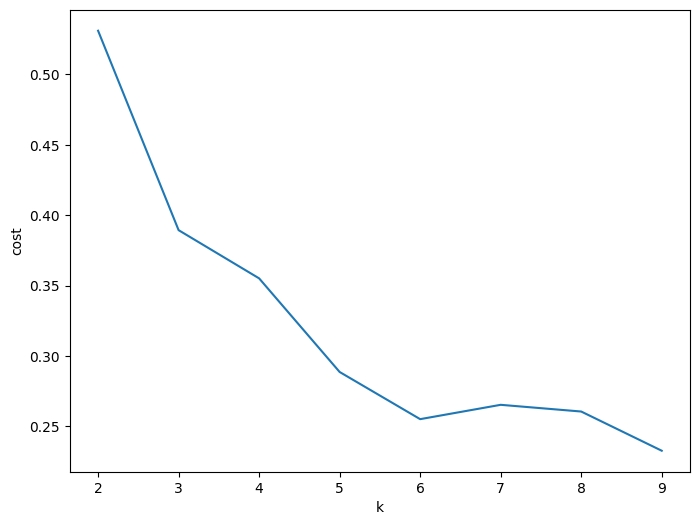

In [19]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("cost")

In [20]:

# Perform clustered sampling from the different clusters
sampling_ratio = 0.018  # Define the sampling ratio, e.g., 80% of the data
seed = 42  # Set a seed for reproducibility

# Get the cluster labels from the output DataFrame
cluster_labels = output.select("prediction").distinct().rdd.flatMap(lambda x: x).collect()

# Perform sampling from each cluster
sampled_data = None

for label in cluster_labels:
    # Filter the data based on the cluster label
    cluster_data = output.filter(col("prediction") == label)

    # Perform clustered sampling on the cluster data
    cluster_sample = cluster_data.sample(False, sampling_ratio, seed)

    # Union the sampled data with the previous clusters' sampled data
    if sampled_data is None:
        sampled_data = cluster_sample
    else:
        sampled_data = sampled_data.union(cluster_sample)

# Show the sampled data
sampled_data.show()



+-------------+--------------+--------------+----------------+----------------+----------------+----------------+------------------+-----------------+------------------+------------------+----------------+---------------+----------------+----------------+----------------+----------------+-------------------------+-------------------------+-------------------------+-------------------------+----------------------+--------------------------+---------------------------+-------------------------+--------------------+--------------------+----------+
|num_instances|num_attributes|dimensionality|num_numeric_attr|pct_numeric_attr|num_nominal_attr|pct_nominal_attr|avg_nominal_values|sd_nominal_values|min_nominal_values|max_nominal_values|avg_numeric_mean|sd_numeric_mean|min_numeric_mean|max_numeric_mean|missing_attr_cnt|missing_attr_pct|missing_instances_max_cnt|missing_instances_max_pct|missing_instances_min_cnt|missing_instances_min_pct|missing_instances_mean|missing_instances_mean_pct|datese

In [21]:
rows = sampled_data.count()
print(f"DataFrame Rows count : {rows}")


DataFrame Rows count : 411


In [22]:
filtered_data_1.dtypes

[('num_instances', 'double'),
 ('num_attributes', 'double'),
 ('dimensionality', 'double'),
 ('num_numeric_attr', 'double'),
 ('pct_numeric_attr', 'double'),
 ('num_nominal_attr', 'double'),
 ('pct_nominal_attr', 'double'),
 ('avg_nominal_values', 'double'),
 ('sd_nominal_values', 'double'),
 ('min_nominal_values', 'double'),
 ('max_nominal_values', 'double'),
 ('avg_numeric_mean', 'double'),
 ('sd_numeric_mean', 'double'),
 ('min_numeric_mean', 'double'),
 ('max_numeric_mean', 'double'),
 ('missing_attr_cnt', 'double'),
 ('missing_attr_pct', 'double'),
 ('missing_instances_max_cnt', 'double'),
 ('missing_instances_max_pct', 'double'),
 ('missing_instances_min_cnt', 'double'),
 ('missing_instances_min_pct', 'double'),
 ('missing_instances_mean', 'double'),
 ('missing_instances_mean_pct', 'double'),
 ('datesets_subject_main_match', 'int'),
 ('datesets_duplicates_match', 'int'),
 ('features', 'vector')]

In [23]:
sampled_data.dtypes

[('num_instances', 'double'),
 ('num_attributes', 'double'),
 ('dimensionality', 'double'),
 ('num_numeric_attr', 'double'),
 ('pct_numeric_attr', 'double'),
 ('num_nominal_attr', 'double'),
 ('pct_nominal_attr', 'double'),
 ('avg_nominal_values', 'double'),
 ('sd_nominal_values', 'double'),
 ('min_nominal_values', 'double'),
 ('max_nominal_values', 'double'),
 ('avg_numeric_mean', 'double'),
 ('sd_numeric_mean', 'double'),
 ('min_numeric_mean', 'double'),
 ('max_numeric_mean', 'double'),
 ('missing_attr_cnt', 'double'),
 ('missing_attr_pct', 'double'),
 ('missing_instances_max_cnt', 'double'),
 ('missing_instances_max_pct', 'double'),
 ('missing_instances_min_cnt', 'double'),
 ('missing_instances_min_pct', 'double'),
 ('missing_instances_mean', 'double'),
 ('missing_instances_mean_pct', 'double'),
 ('datesets_subject_main_match', 'int'),
 ('datesets_duplicates_match', 'int'),
 ('features', 'vector'),
 ('standardized', 'vector'),
 ('prediction', 'int')]

In [24]:
sampled_data=sampled_data.drop("standardized","prediction")
sampled_data


num_instances,num_attributes,dimensionality,num_numeric_attr,pct_numeric_attr,num_nominal_attr,pct_nominal_attr,avg_nominal_values,sd_nominal_values,min_nominal_values,max_nominal_values,avg_numeric_mean,sd_numeric_mean,min_numeric_mean,max_numeric_mean,missing_attr_cnt,missing_attr_pct,missing_instances_max_cnt,missing_instances_max_pct,missing_instances_min_cnt,missing_instances_min_pct,missing_instances_mean,missing_instances_mean_pct,datesets_subject_main_match,datesets_duplicates_match,features
0.867164,0.222222,0.829211,0.133333,0.102564,0.666667,0.571429,0.993328,1.0,0.0,0.99776,0.891627,0.824497,0.0,0.835281,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.867164,0.22222..."
0.946548,0.794872,0.739421,0.142857,0.824176,0.969697,0.852273,0.965909,1.0,1.0,0.854167,0.800464,0.811472,0.0,0.772763,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.946548,0.79487..."
0.930958,0.717949,0.755214,0.4,0.830769,0.969697,0.892562,0.973607,1.0,1.0,0.887097,0.806692,0.803485,0.5,0.77593,0.827586,0.388715,0.98441,0.774194,0.953488,0.326332,0.993924,0.912001,0,0,"[0.930958,0.71794..."
0.999731,0.384615,0.999563,0.461538,0.125,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.988486,1.0,0.993031,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.999731,0.38461..."
0.9988,0.2,0.9985,0.357143,0.196429,0.666667,0.733333,0.666667,1.0,0.7,0.6,1.0,0.977769,1.0,0.9875,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.9988,0.2,0.998..."
0.810127,0.25,0.857595,0.4375,0.25,1.0,1.0,1.0,1.0,1.0,1.0,0.860081,0.943278,0.0,0.95872,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.810127,0.25,0...."
0.949472,0.3125,0.965262,0.222222,0.465278,0.888889,0.838384,0.465347,1.0,0.666667,0.853659,0.999689,0.999259,1.0,0.999257,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.949472,0.3125,..."
0.999893,0.8,0.999466,0.0,0.8,0.977778,0.888889,0.96595,1.0,0.967742,0.887097,0.919301,0.908835,0.857143,0.90436,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.999893,0.8,0.9..."
0.979034,0.8,0.895172,0.0,0.8,0.923077,0.615385,0.570248,1.0,0.5,0.902439,0.999098,0.999489,0.72973,0.999294,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.979034,0.8,0.8..."
0.994533,0.125,0.993752,0.461538,0.528846,0.888889,0.873016,0.732673,1.0,0.333333,0.926829,0.997668,0.996992,1.0,0.996064,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.994533,0.125,0..."


In [25]:
result = sampled_data.union(filtered_data_1)

In [26]:
result.count()

539

### Modeling

In [27]:
rf=RandomForestClassifier(labelCol="datesets_duplicates_match", featuresCol="features")

# Define the parameter grid for tuning
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# Create a Leave-One-Out Cross Validator
crossval = CrossValidator(estimator=RandomForestClassifier(labelCol="datesets_duplicates_match", featuresCol="features"),
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="datesets_duplicates_match", predictionCol="prediction", metricName="accuracy"))


# Fit the model using the cross validator
model = crossval.fit(result)

# Get the best model from cross validation
best_model = model.bestModel

# Make predictions on the entire dataset
predictions = best_model.transform(result)



### Evaluation

In [30]:
# Calculate TP, TN, FP, FN from the predictions
TP = predictions.filter("datesets_duplicates_match = 1 AND prediction = 1").count()
TN = predictions.filter("datesets_duplicates_match = 0 AND prediction = 0").count()
FP = predictions.filter("datesets_duplicates_match = 0 AND prediction = 1").count()
FN = predictions.filter("datesets_duplicates_match = 1 AND prediction = 0").count()

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Calculate Precision
precision = TP / (TP + FP)

# Calculate Recall
recall = TP / (TP + FN)

# Calculate F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)




# Print the results
print("Accuracy: {:.2f}".format(accuracy * 100))
print("Precision: {:.2f}".format(precision * 100))
print("Recall: {:.2f}".format(recall * 100))
print("F1 Score: {:.2f}".format(f1_score * 100))


Accuracy: 99.44
Precision: 99.21
Recall: 98.44
F1 Score: 98.82
